In [11]:
import numpy as np
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import product

In [2]:
def read_off(file_path):
    with open(file_path, 'r') as file:
        # Read the header
        header = file.readline().strip()
        if header != 'OFF':
            raise ValueError('Not a valid OFF file')

        # Read number of vertices, faces, and edges
        n_verts, n_faces, _ = map(int, file.readline().strip().split())

        # Read vertex coordinates
        vertices = []
        for _ in range(n_verts):
            vertex = list(map(float, file.readline().strip().split()))
            vertices.append(vertex)
        vertices = np.array(vertices)

        # Read faces (index of vertices)
        faces = []
        for _ in range(n_faces):
            face_info = list(map(int, file.readline().strip().split()))
            face = face_info[1:]  # Ignore the first number (number of vertices in the face)
            faces.append(face)
        faces = np.array(faces)

        # Center the model: subtract the centroid of the vertices
    centroid = np.mean(vertices, axis=0)
    vertices -= centroid

    # Normalize the size: scale vertices to fit within a unit sphere
    max_distance = np.max(np.linalg.norm(vertices, axis=1))
    vertices /= max_distance

    return vertices, faces


In [5]:
def visualize_model(vertices, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a Poly3DCollection object
    mesh = Poly3DCollection(vertices[faces], alpha=0.5)
    
    # Add the collection to the axes
    ax.add_collection3d(mesh)

    # Set limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Auto scale to the mesh size
    scale = vertices.flatten()
    ax.auto_scale_xyz(scale, scale, scale)

    plt.show()

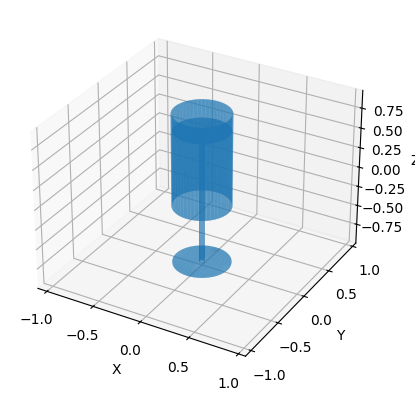

In [45]:
label = "lamp"
n = "0004"
model = f"./ModelNet40/{label}/train/{label}_{n}.off"

vertices, faces = read_off(model)
visualize_model(vertices, faces)

In [12]:
import numpy as np
from scipy.ndimage import binary_fill_holes
from itertools import product

def voxelize_surface(vertices, faces, voxel_size=1.0, grid_padding=1):
    # 1. Calculate bounding box of vertices
    min_corner = vertices.min(axis=0) - grid_padding * voxel_size
    max_corner = vertices.max(axis=0) + grid_padding * voxel_size
    grid_size = np.ceil((max_corner - min_corner) / voxel_size).astype(int)

    # 2. Create the voxel grid
    voxel_grid = np.zeros(grid_size, dtype=bool)
    
    # 3. Map vertices to voxel indices
    voxel_indices = np.floor((vertices - min_corner) / voxel_size).astype(int)

    # 4. Rasterize each triangle face into the voxel grid
    def rasterize_triangle(v0, v1, v2):
        # Find bounding box of the triangle in voxel coordinates
        tri_min = np.min([v0, v1, v2], axis=0)
        tri_max = np.max([v0, v1, v2], axis=0)
        
        # Iterate over bounding box voxels
        for x, y, z in product(
            range(tri_min[0], tri_max[0] + 1),
            range(tri_min[1], tri_max[1] + 1),
            range(tri_min[2], tri_max[2] + 1),
        ):
            voxel = np.array([x, y, z])
            
            # Check if voxel center is inside the triangle
            if point_in_triangle(voxel, v0, v1, v2):
                voxel_grid[tuple(voxel)] = True

    # 5. Loop over each face to voxelize it
    for face in faces:
        v0, v1, v2 = voxel_indices[face[0]], voxel_indices[face[1]], voxel_indices[face[2]]
        rasterize_triangle(v0, v1, v2)
    
    # 6. Fill the interior (optional)
    filled_voxel_grid = binary_fill_holes(voxel_grid)

    return filled_voxel_grid

# Helper function to check if a point is within a 3D triangle using barycentric coordinates
def point_in_triangle(p, v0, v1, v2):
    v0, v1, v2, p = np.array(v0), np.array(v1), np.array(v2), np.array(p)
    u = v1 - v0
    v = v2 - v0
    w = p - v0

    uu = np.dot(u, u)
    uv = np.dot(u, v)
    vv = np.dot(v, v)
    wu = np.dot(w, u)
    wv = np.dot(w, v)

    denom = uv * uv - uu * vv
    s = (uv * wv - vv * wu) / denom
    t = (uv * wu - uu * wv) / denom

    return s >= 0 and t >= 0 and (s + t) <= 1

# Example usage:
# vertices = np.array([[0, 0, 0], [1, 1, 1], [2, 0, 0], [1, -1, 1]])  # Example vertices
# faces = np.array([[0, 1, 2], [1, 2, 3]])  # Example faces
# voxel_grid = voxelize_surface(vertices, faces, voxel_size=0.5)


In [29]:
def visualize_voxels(voxel_grid):
    # Find the x, y, z coordinates of filled voxels
    filled_voxels = np.argwhere(voxel_grid)
    x, y, z = filled_voxels[:, 0], filled_voxels[:, 1], filled_voxels[:, 2]

    # Plot using Matplotlib
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, zdir='z', c='b', marker='s')

    # Customize plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("3D Voxel Visualization")
    plt.show()

/tmp/ipykernel_234016/4250958880.py:59: RuntimeWarning: invalid value encountered in scalar divide
  s = (uv * wv - vv * wu) / denom
/tmp/ipykernel_234016/4250958880.py:60: RuntimeWarning: invalid value encountered in scalar divide
  t = (uv * wu - uu * wv) / denom


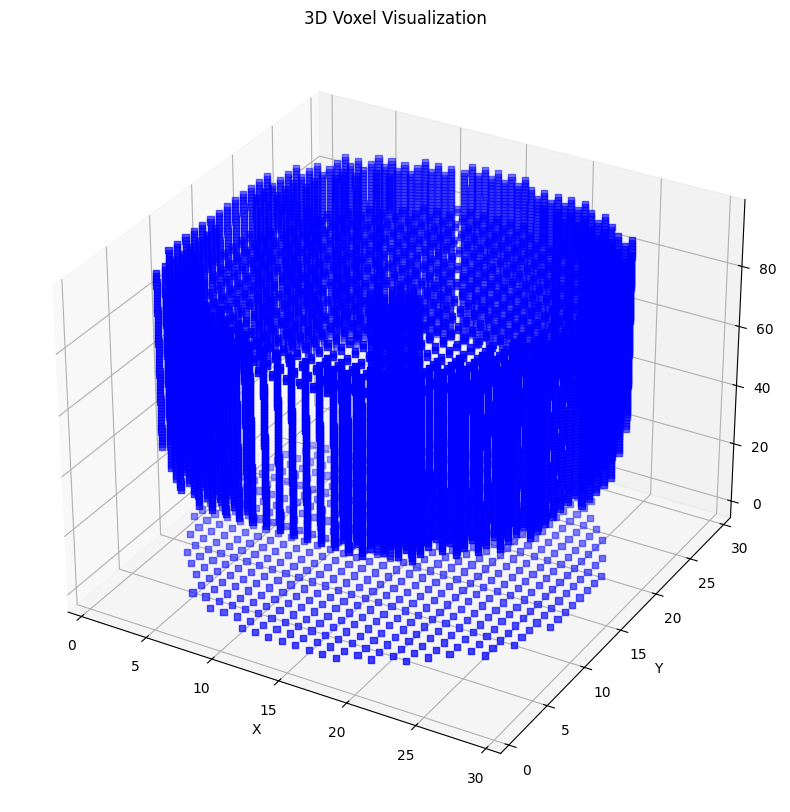

In [46]:
voxels = voxelize_surface(vertices, faces, voxel_size=0.02, grid_padding=1)
visualize_voxels(voxels)

In [38]:
import pyvista as pv
def visualize_voxels_pyvista(voxel_grid, voxel_size=1.0):
    # Get the coordinates of filled voxels
    filled_voxels = np.argwhere(voxel_grid)
    
    # Create a PyVista plotter
    plotter = pv.Plotter()
    
    # Iterate over filled voxels and add each as a cube
    for x, y, z in filled_voxels:
        cube = pv.Cube(center=(x * voxel_size, y * voxel_size, z * voxel_size), x_length=voxel_size, y_length=voxel_size, z_length=voxel_size)
        plotter.add_mesh(cube, color="cyan", show_edges=False)
    
    # Display the interactive plot
    plotter.show()


/home/achraf/anaconda3/envs/py310/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/achraf/anaconda3/envs/py310/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


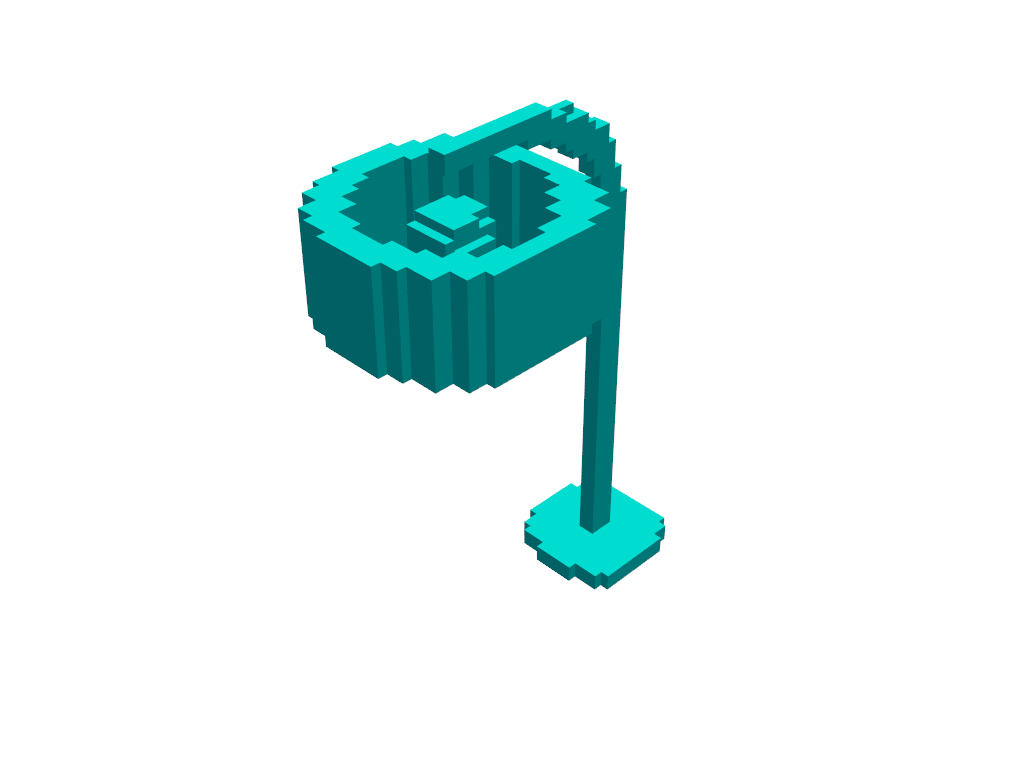

In [41]:
visualize_voxels_pyvista(voxels, voxel_size=)